# Baseline YOLOPX performance on day vs. night BDD100K data



This notebook loads and splits the BDD100K dataset into daytime and night instances, using the **select_data** function in **bdd.py**. It also loads the pretrained YOLOPX model **(epoch-195.pth)** and runs it on the split validation sets of the day and nighttime images. Finally, it will evaluate the pretrained models performance on the combined data, the daytime data and the night data. This notebook will closely follow the **test.py** script.

In [1]:
import argparse
import os, sys

path = os.getcwd()
BASE_DIR = os.path.dirname(os.path.dirname(path))
print(BASE_DIR)
assert(os.path.basename(BASE_DIR) == "LightSB_YOLO")
YOLOPX_DIR = os.path.join(BASE_DIR, "", "models\YOLOPX")

sys.path.append(YOLOPX_DIR)
print(YOLOPX_DIR)


c:\Users\joche\Development\Github\LightSB_YOLO
c:\Users\joche\Development\Github\LightSB_YOLO\models\YOLOPX


In [2]:
import pprint
import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import numpy as np
from lib.utils import DataLoaderX
from tensorboardX import SummaryWriter

import lib.dataset as dataset
from lib.config import cfg
from lib.config import update_config
from lib.core.loss import get_loss
from lib.core.function import validate
from lib.core.general import fitness
from lib.models import get_net
from lib.utils.utils import create_logger, select_device

c:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Setup Namespace
...


In [4]:
from argparse import Namespace

In [5]:
args = Namespace()
args.iou_thres = 0.6
args.conf_thres = 0.001
args.weights = "../weights/epoch-195.pth"
args.modelDir = ''
args.logDir = 'runs/'

# annotations directory setup
args.da_seg_annotations = os.path.join(BASE_DIR, '', 'data/da_seg_annotations')
args.det_annotations = os.path.join(BASE_DIR, '', 'data/det_annotations')
args.images = os.path.join(BASE_DIR, '', 'data/images')
args.ll_seg_annotations = os.path.join(BASE_DIR, '', 'data/ll_seg_annotations')

In [6]:
update_config(cfg, args)

In [7]:
logger, final_output_dir, tb_log_dir = create_logger(
        cfg, cfg.LOG_DIR, 'test')

logger.info(pprint.pformat(args))
logger.info(cfg)

writer_dict = {
    'writer': SummaryWriter(log_dir=tb_log_dir),
    'train_global_steps': 0,
    'valid_global_steps': 0,
}


Namespace(conf_thres=0.001, da_seg_annotations='C:\\Users\\joche\\OneDrive\\Documents\\Github\\LightSB_YOLO\\data/da_seg_annotations', det_annotations='C:\\Users\\joche\\OneDrive\\Documents\\Github\\LightSB_YOLO\\data/det_annotations', images='C:\\Users\\joche\\OneDrive\\Documents\\Github\\LightSB_YOLO\\data/images', iou_thres=0.6, ll_seg_annotations='C:\\Users\\joche\\OneDrive\\Documents\\Github\\LightSB_YOLO\\data/ll_seg_annotations', logDir='runs/', modelDir='', weights='../weights/epoch-195.pth')
AUTO_RESUME: False
CUDNN:
  BENCHMARK: True
  DETERMINISTIC: False
  ENABLED: True
DATASET:
  COLOR_RGB: False
  DATAROOT: C:\Users\joche\OneDrive\Documents\Github\LightSB_YOLO\data/images
  DATASET: BddDataset
  DATA_FORMAT: jpg
  FLIP: True
  HSV_H: 0.015
  HSV_S: 0.7
  HSV_V: 0.4
  LABELROOT: C:\Users\joche\OneDrive\Documents\Github\LightSB_YOLO\data/det_annotations
  LANEROOT: C:\Users\joche\OneDrive\Documents\Github\LightSB_YOLO\data/ll_seg_annotations
  MASKROOT: C:\Users\joche\OneDr

=> creating runs\BddDataset\_2025-12-27-10-57


In [8]:
device = select_device(logger, batch_size=cfg.TEST.BATCH_SIZE_PER_GPU* len(cfg.GPUS)) if not cfg.DEBUG \
            else select_device(logger, 'cpu')

Using torch 1.12.1+cu113 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4095MB)



# Get Model

In [9]:
model = get_net(cfg)
criterion = get_loss(cfg, device, model)

In [10]:
model_dict = model.state_dict()
checkpoint_file = args.weights
logger.info("=> loading checkpoint '{}'".format(checkpoint_file))
checkpoint = torch.load(checkpoint_file, map_location=device)
checkpoint_dict = checkpoint['state_dict']
# checkpoint_dict = {k: v for k, v in checkpoint['state_dict'].items() if k.split(".")[1] in det_idx_range}
model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
logger.info("=> loaded checkpoint '{}' ".format(checkpoint_file))

model = model.to(device)
model.gr = 1.0
model.nc = 1
print('bulid model finished')

=> loading checkpoint '../weights/epoch-195.pth'
=> loaded checkpoint '../weights/epoch-195.pth' 


bulid model finished


In [11]:
print(model)

MCnet(
  (model): Sequential(
    (0): ELANNet(
      (layer_1): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (2): Conv(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
      )
      (layer_2): Sequential(
        (0): Conv(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

# Build Dataset

In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

valid_dataset = eval('dataset.' + cfg.DATASET.DATASET)(
    cfg=cfg,
    is_train=False,
    inputsize=cfg.MODEL.IMAGE_SIZE,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

valid_dataset.db = valid_dataset.select_data('daytime')

valid_loader = DataLoaderX(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)
print('load data finished')

C:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


building database...


100%|██████████| 10000/10000 [00:03<00:00, 2818.52it/s]

database build finish
load data finished


  0%|          | 0/658 [00:00<?, ?it/s]C:\Users\joche\anaconda3\envs\yolopx_lightsb\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 658/658 [06:39<00:00,  1.65it/s]
Test:    Loss(0.448)
Driving area Segment: Acc(0.981)    IOU (0.893)    mIOU(0.935)
Lane line Segment: Acc(0.896)    IOU (0.277)  mIOU(0.629)
Detect: P(0.037)  R(0.938)  mAP@0.5(0.852)  mAP@0.5:0.95(0.517)
Time: inference(0.0345s/frame)  nms(0.0039s/frame)


                 all    5.26e+03    6.21e+04       0.037       0.938       0.852       0.517
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to runs\BddDataset\_2025-12-24-14-25\visualization
test finish


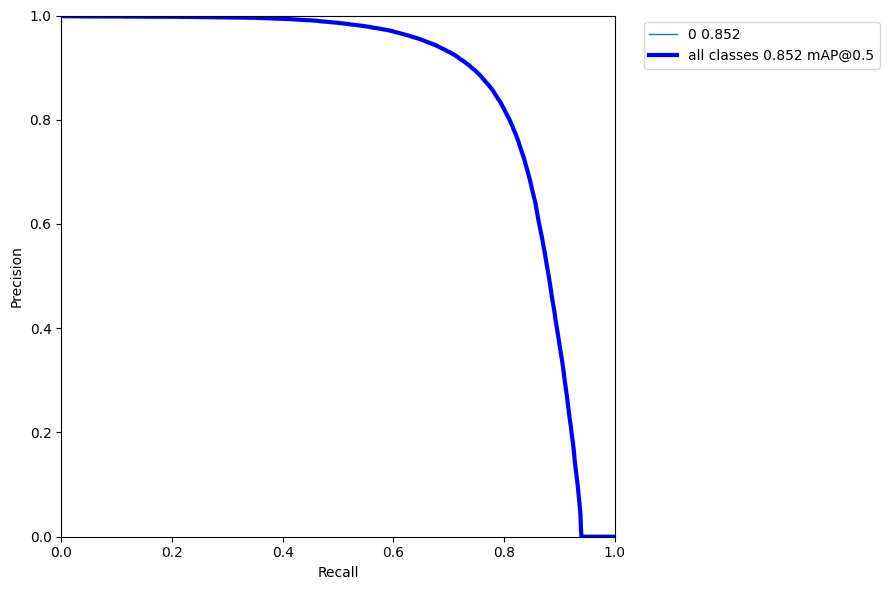

In [12]:
epoch = 0 #special for test
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, valid_dataset, model, criterion,
    final_output_dir, tb_log_dir, writer_dict,
    logger, device
)
fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])
logger.info(msg)
print("test finish")

In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

valid_dataset = eval('dataset.' + cfg.DATASET.DATASET)(
    cfg=cfg,
    is_train=False,
    inputsize=cfg.MODEL.IMAGE_SIZE,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

valid_dataset.db = valid_dataset.select_data('night')

valid_loader = DataLoaderX(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)
print('load data finished')

building database...


100%|██████████| 10000/10000 [00:05<00:00, 1789.72it/s]

database build finish
load data finished


100%|██████████| 492/492 [04:57<00:00,  1.65it/s]
Test:    Loss(0.506)
Driving area Segment: Acc(0.977)    IOU (0.880)    mIOU(0.927)
Lane line Segment: Acc(0.867)    IOU (0.264)  mIOU(0.622)
Detect: P(0.029)  R(0.935)  mAP@0.5(0.794)  mAP@0.5:0.95(0.429)
Time: inference(0.0348s/frame)  nms(0.0040s/frame)


                 all    3.93e+03     3.7e+04      0.0293       0.935       0.794       0.429
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to runs\BddDataset\_2025-12-24-14-25\visualization
test finish


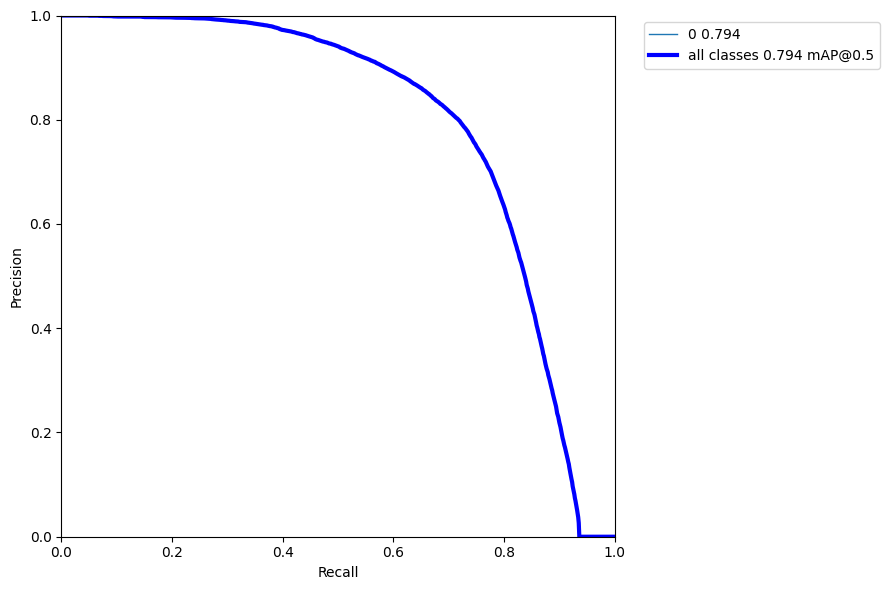

In [14]:
epoch = 0 #special for test
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, valid_dataset, model, criterion,
    final_output_dir, tb_log_dir, writer_dict,
    logger, device
)
fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])
logger.info(msg)
print("test finish")

building database...


100%|██████████| 10000/10000 [00:04<00:00, 2435.43it/s]


database build finish
load data finished


100%|██████████| 1153/1153 [10:43<00:00,  1.79it/s]
Test:    Loss(0.471)
Driving area Segment: Acc(0.979)    IOU (0.888)    mIOU(0.931)
Lane line Segment: Acc(0.883)    IOU (0.272)  mIOU(0.626)
Detect: P(0.034)  R(0.937)  mAP@0.5(0.832)  mAP@0.5:0.95(0.485)
Time: inference(0.0338s/frame)  nms(0.0037s/frame)


                 all    9.22e+03    9.93e+04      0.0336       0.937       0.832       0.485
Speed: 0.0/0.0/0.0 ms inference/NMS/total per 640x640 image at batch-size 8
Results saved to runs\BddDataset\_2025-12-24-14-25\visualization
test finish


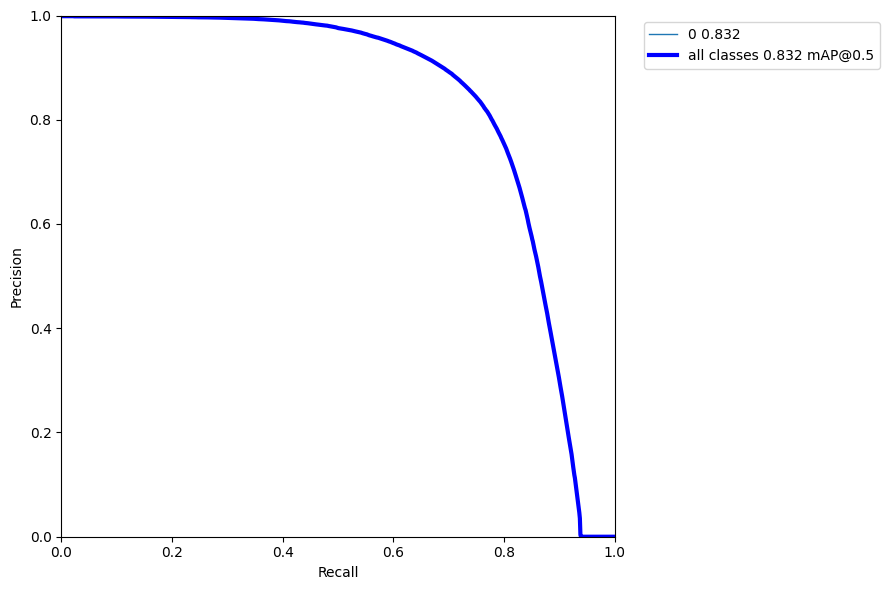

In [ ]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

valid_dataset = eval('dataset.' + cfg.DATASET.DATASET)(
    cfg=cfg,
    is_train=False,
    inputsize=cfg.MODEL.IMAGE_SIZE,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

valid_dataset.db = valid_dataset.select_data('all')

valid_loader = DataLoaderX(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU * len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=False,
    collate_fn=dataset.AutoDriveDataset.collate_fn
)
print('load data finished')
epoch = 0 #special for test
da_segment_results,ll_segment_results,detect_results, total_loss,maps, times = validate(
    epoch,cfg, valid_loader, valid_dataset, model, criterion,
    final_output_dir, tb_log_dir, writer_dict,
    logger, device
)
fi = fitness(np.array(detect_results).reshape(1, -1))
msg =   'Test:    Loss({loss:.3f})\n' \
        'Driving area Segment: Acc({da_seg_acc:.3f})    IOU ({da_seg_iou:.3f})    mIOU({da_seg_miou:.3f})\n' \
                  'Lane line Segment: Acc({ll_seg_acc:.3f})    IOU ({ll_seg_iou:.3f})  mIOU({ll_seg_miou:.3f})\n' \
                  'Detect: P({p:.3f})  R({r:.3f})  mAP@0.5({map50:.3f})  mAP@0.5:0.95({map:.3f})\n'\
                  'Time: inference({t_inf:.4f}s/frame)  nms({t_nms:.4f}s/frame)'.format(
                      loss=total_loss, da_seg_acc=da_segment_results[0],da_seg_iou=da_segment_results[1],da_seg_miou=da_segment_results[2],
                      ll_seg_acc=ll_segment_results[0],ll_seg_iou=ll_segment_results[1],ll_seg_miou=ll_segment_results[2],
                      p=detect_results[0],r=detect_results[1],map50=detect_results[2],map=detect_results[3],
                      t_inf=times[0], t_nms=times[1])
logger.info(msg)
print("test finish")

# Error Analysis